In [1]:
# Imports
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pypdf import PdfWriter

from geoscripts import gchemplots as gp
from geoscripts import gchemcalc as gc

pd.options.mode.copy_on_write = True

2024-04-07 10:03:31,908 pyrolite.util.plot.helpers - WARNING: scikit-learn not installed
/home/dyvasey/miniforge3/envs/dev-geoscripts-gchem/lib/python3.11/site-packages/mpltern/ternary/datasets.py:9: UserWarning: `mpltern.ternary.datasets.py` has been moved to `mpltern.datasets.py` and will be removed from the present directory in mpltern 0.6.0.
  warnings.warn(msg)


In [2]:
# Set up directory
savedir = 'draft_figs/'
os.makedirs(savedir,exist_ok=True)

In [3]:
# New Data
data = pd.read_csv('processed/data.csv',index_col=0)

# Filter for J
filter_period = (data['Period']=='Jurassic')|(data['Period']=='Jurassic?')
data_filt = data[filter_period]
print(data_filt.index)

Index(['G22019', 'G22020', 'G22032A', 'G22033', 'G22034', 'G22035', 'G22036A',
       'G22037', 'G22038', 'G22039', 'G22041A', 'G22041C', 'G22042', 'G22044',
       'G22045', 'G22046C', 'G22049', 'G22051', 'G22053', 'G22063', 'G22065',
       'G22066', 'G22067', 'G22068A', 'G22068B', 'G22068C', 'G22069', 'G22076',
       'G22081', 'G22091', 'G22092', 'G22094', 'G22096', 'G22108A', 'G22109',
       'G22110', 'G22111', 'G22114', 'G22118', 'G22119', 'G22125', 'G22126',
       'G22129', 'G22130', 'G22131', 'G22141', 'C17069B', '100311-3A'],
      dtype='object')


In [4]:
# Groups
khaishi_core_smps = ['G22034','G22035','G22036A','G22037','G22038','G22039']
data_filt.loc[khaishi_core_smps,'S_Domain'] = 'Khaishi Core'

limb_condition = (~data_filt.index.isin(khaishi_core_smps)) & (data_filt['S_Domain'] == 'Khaishi')
data_filt.loc[limb_condition,'S_Domain'] = 'Khaishi Limbs'

group_dict = {'Khaishi Core':'Khaishi Core','Khaishi Limbs':'Khaishi Limbs','Idliani':'Idliani','Jvari':'Jvari','Lentekhi':'Lentekhi/Panaga','Mazashi':'Mazashi','Panaga':'Lentekhi/Panaga',
              'Tsageri-Khvamli':'Tsageri-Khvamli','Dzirula':np.nan,'Pasanauri':np.nan,'Dizi':np.nan,'Cretaceous Intrusive':np.nan}

chem_group = data_filt['S_Domain'].map(group_dict)

groups = data_filt.groupby(chem_group,sort=False)

color_dict = {'Khaishi Core':'#88CCEE','Khaishi Limbs':'#44AA99','Idliani':'#117733','Jvari':'#999933','Lentekhi/Panaga':'#AA4499','Mazashi':'#882255','Tsageri-Khvamli':'#CC6677',
              np.nan:'#DDDDDD'}

axes_dict = {'Khaishi Core':(0,0),'Khaishi Limbs':(0,0),'Idliani':(1,0),'Jvari':(2,0),'Lentekhi/Panaga':(0,1),'Mazashi':(1,1),'Tsageri-Khvamli':(2,1)}

In [5]:
# Save Data
data_filt['Color'] = chem_group.map(color_dict)
plot_data = data_filt[data_filt['Color']!='#DDDDDD']

plot_data.to_csv(savedir+'data.csv')

In [6]:
# Old Data
gale = pd.read_csv('processed/data_gale.csv')

cbab = pd.read_excel('published/Vasey_CaucArc_TableS4.xlsx',header=1)
spreading_cond = cbab['Region'].isin(['Okinawa Trough','Bransfield Strait','Tyrrhenian Sea'])
cbab_spread = cbab[spreading_cond]

avgs_raw = pd.read_csv('published/Vasey21_avgs.csv',header=0,index_col=0)
avgs = avgs_raw.loc[['D-MORB','E-MORB','Oceanic Arc','OIB'],:]
avgs_colors = {'D-MORB':'#997700','E-MORB':'#EECC66','Oceanic Arc':'#6699CC','OIB':'#EE99AA'}

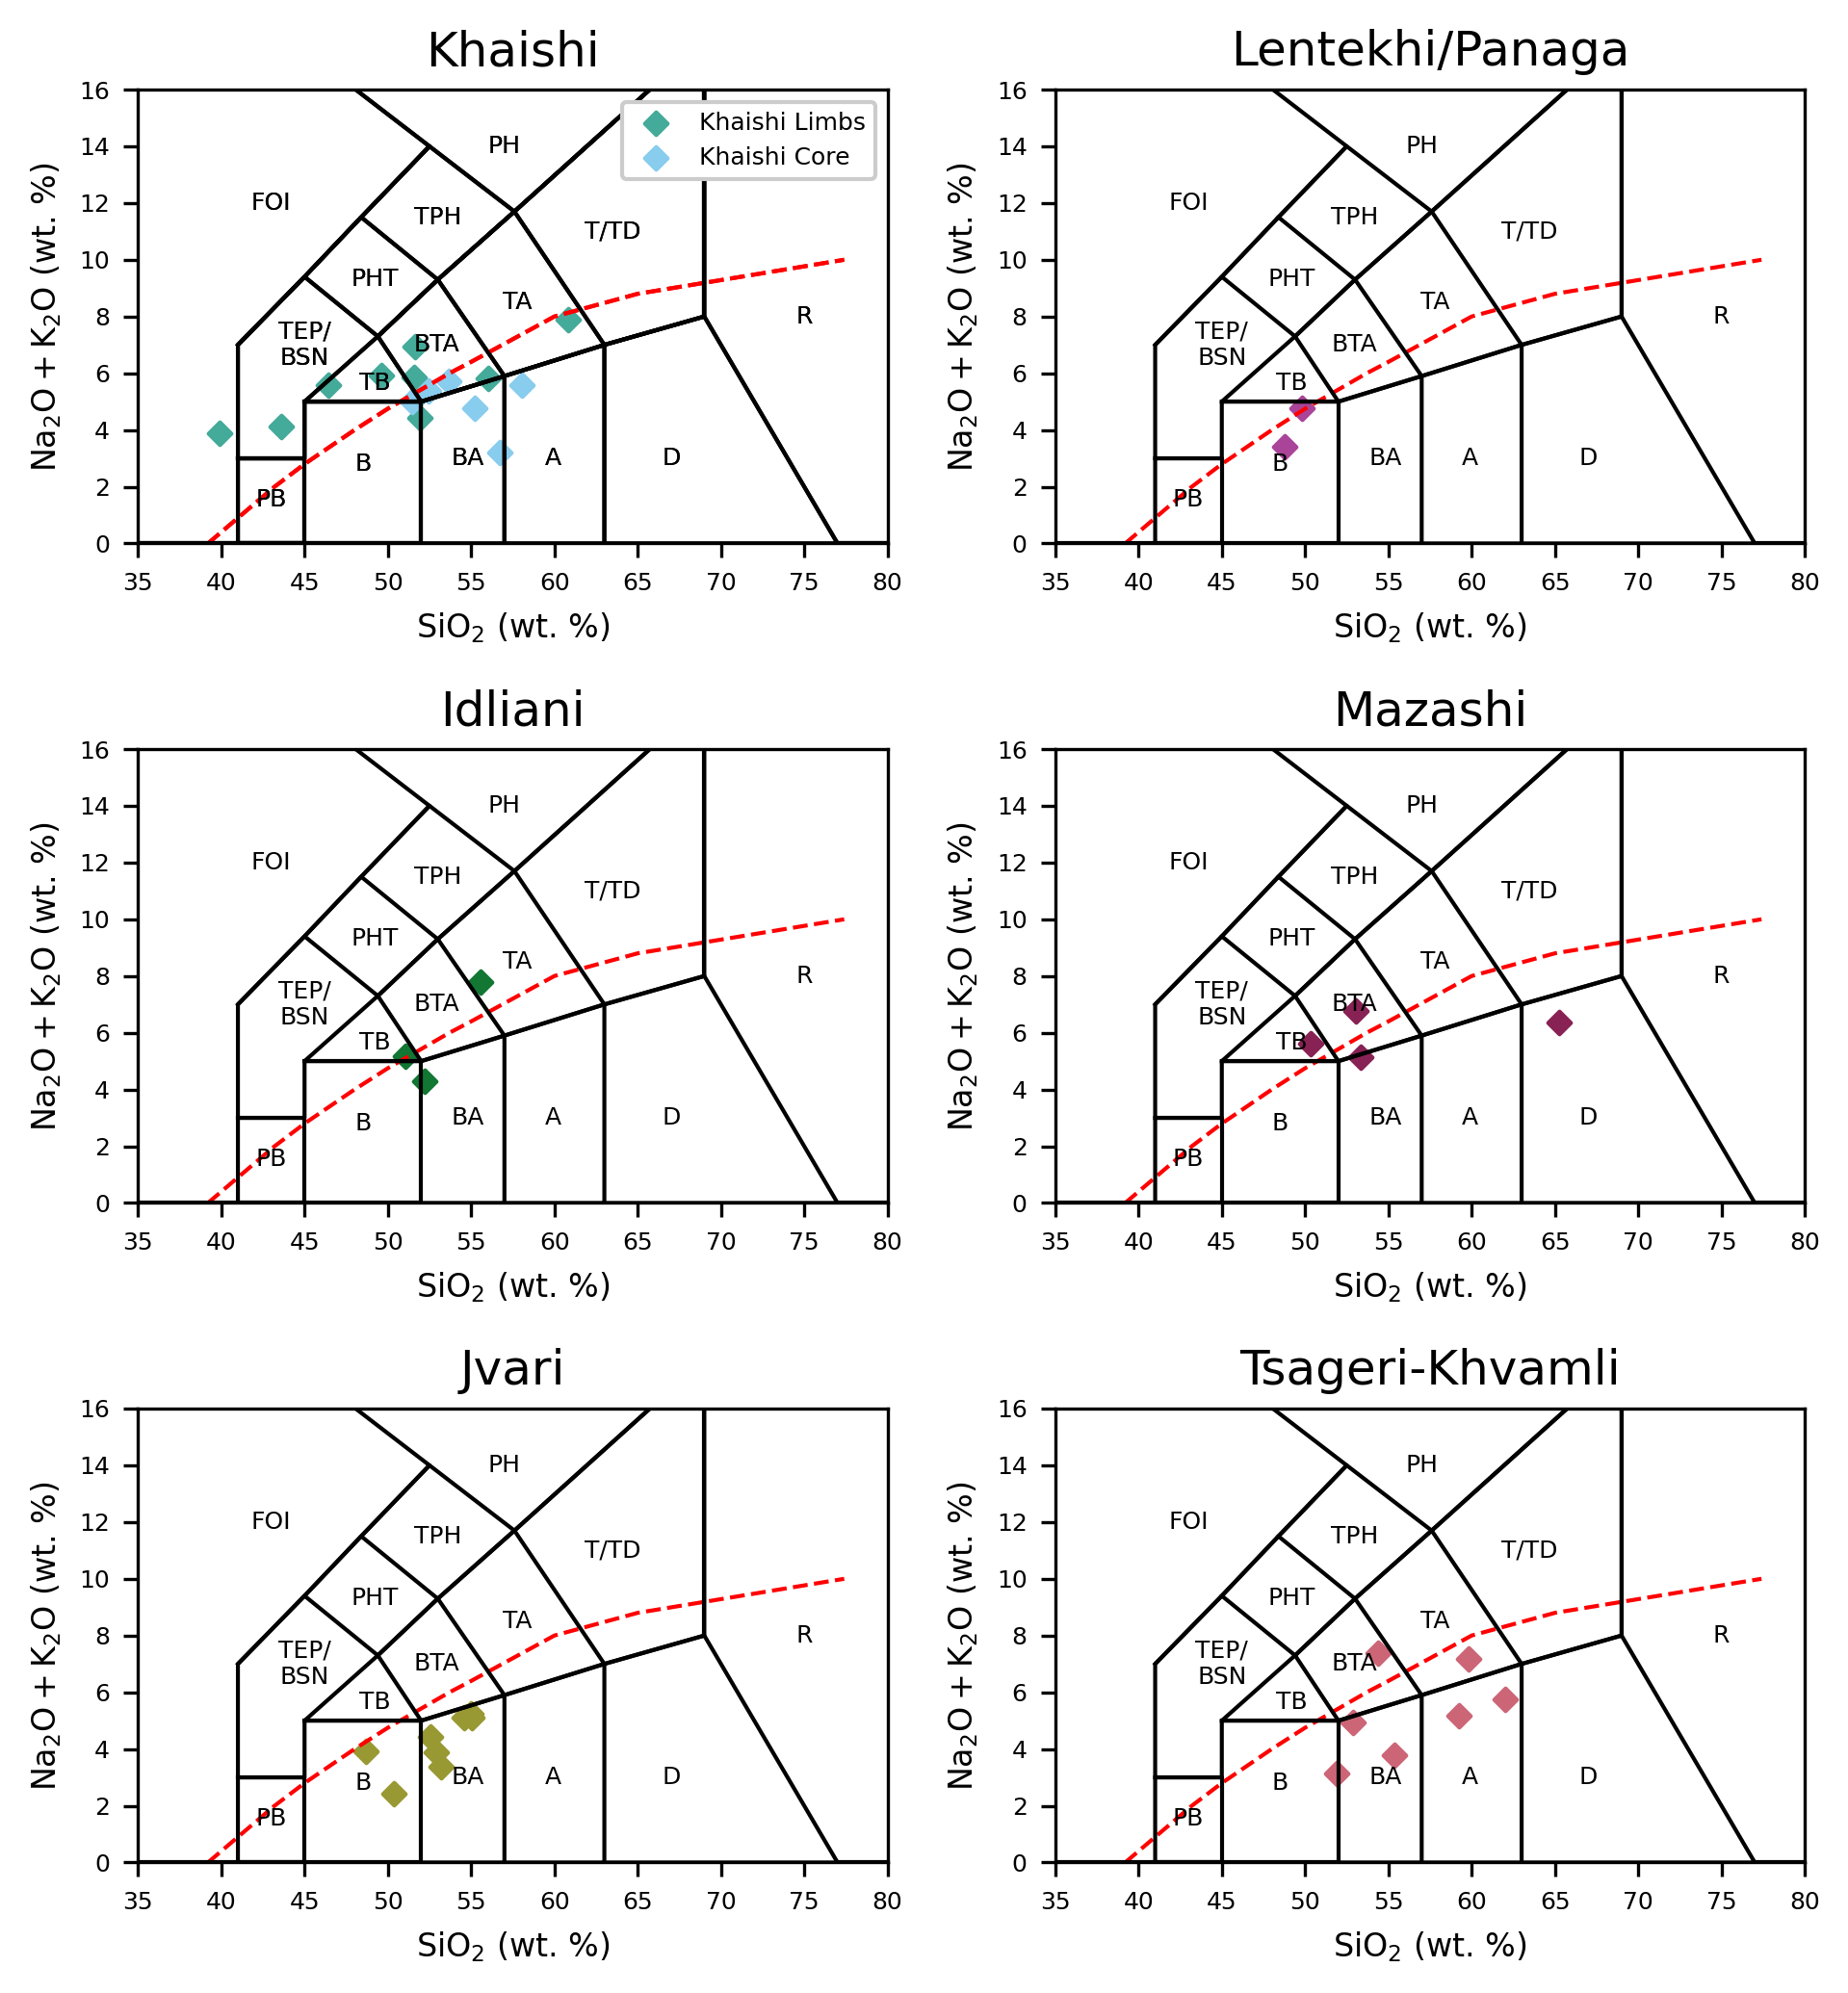

In [7]:
# TAS
fig,axs = plt.subplots(3,2,dpi=300,figsize=(6.5,7))

for k, group in groups:
    ax = axs[axes_dict[k]]
    color = color_dict[k]
    SiO2,Na2O,K2O = group[['SiO2','Na2O','K2O']].T.values
    gp.TASsm(SiO2,Na2O,K2O,label=k,ax=ax,color=color,first=[])
    ax.set_title(k)
axs[0,0].set_title('Khaishi')
axs[0,0].legend(fontsize=6,loc='upper right',frameon=True,framealpha=1,facecolor='white')

plt.tight_layout()

fig.savefig(savedir+'F04_TAS.pdf')

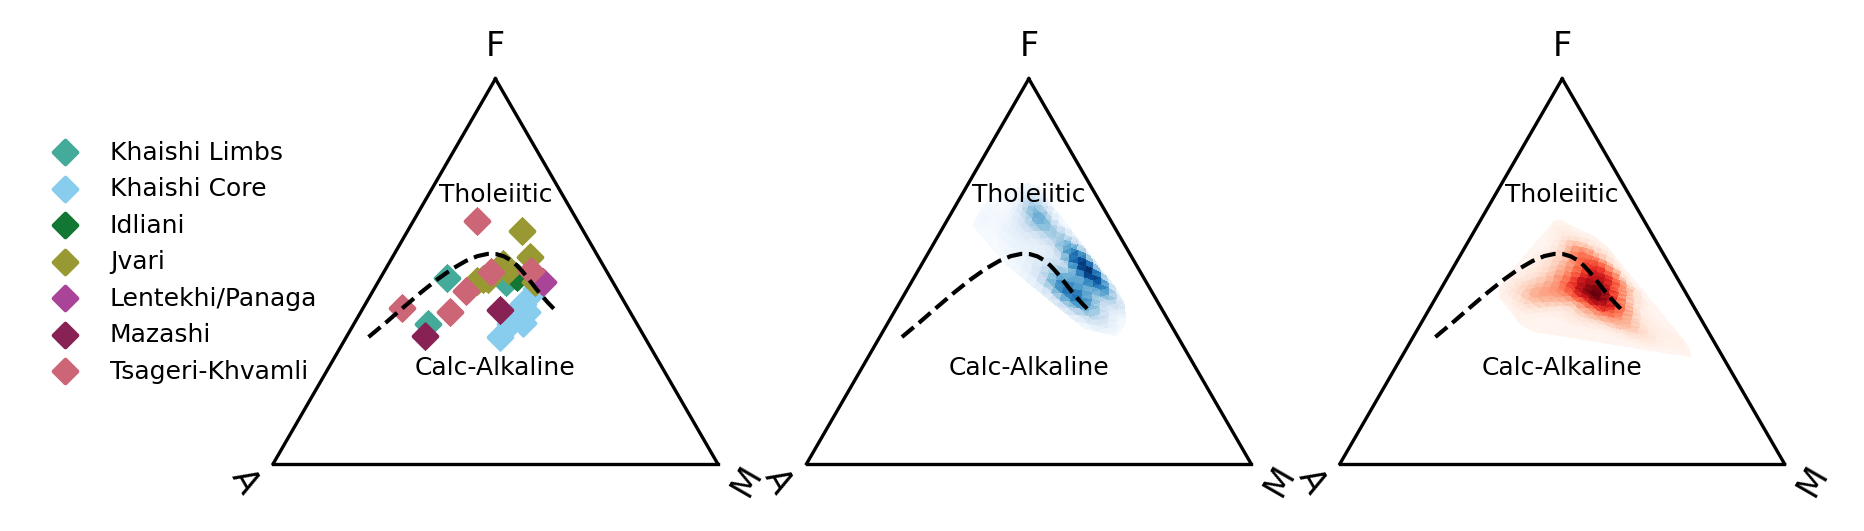

In [8]:
# AFM
fig,axs = plt.subplots(1,3,figsize=(6.5,3),dpi=300,subplot_kw={'projection':'ternary'})

first = []
for k,group in groups:
    group_sub = gc.classifyAlkaline(group)
    group_filt = group[group_sub]

    gp.afm(Na2O=group_filt['Na2O'],K2O=group_filt['K2O'],FeOt=group_filt['FeO*'],MgO=group_filt['MgO'],ax=axs[0],scatter=True,
       density=False,scatter_kwargs={'color':color_dict[k],'label':k},first=first)

gale_sub = gc.classifyAlkaline(gale)
gale_filt = gale[gale_sub]

gp.afm(Na2O=gale_filt['Na2O'],K2O=gale_filt['K2O'],FeOt=gale_filt['FeOt'],MgO=gale_filt['MgO'],ax=axs[1],scatter=False,
       density=True,first=[],density_kwargs={'cmap':'Blues'})

cbab_sub = gc.classifyAlkaline(cbab_spread)
cbab_filt = cbab_spread[cbab_sub]

gp.afm(Na2O=cbab_filt['Na2O'],K2O=cbab_filt['K2O'],FeOt=cbab_filt['FeOt'],MgO=cbab_filt['MgO'],ax=axs[2],scatter=False,
       density=True,first=[],density_kwargs={'cmap':'Reds'})

axs[0].legend(fontsize=6,loc='best',bbox_to_anchor=(0.15,0.9))

fig.savefig(savedir+'F05_AFM.pdf')

4
4
4
4
4
4
4
4


/home/dyvasey/miniforge3/envs/dev-geoscripts-gchem/lib/python3.11/site-packages/pyrolite/plot/spider.py:276: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(_ymin, _ymax)
/home/dyvasey/miniforge3/envs/dev-geoscripts-gchem/lib/python3.11/site-packages/pyrolite/plot/spider.py:276: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(_ymin, _ymax)
/home/dyvasey/miniforge3/envs/dev-geoscripts-gchem/lib/python3.11/site-packages/pyrolite/plot/spider.py:276: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(_ymin, _ymax)
/home/dyvasey/miniforge3/envs/dev-geoscripts-gchem/lib/python3.11/site-packages/pyrolite/plot/spider.py:276: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(_ymin, _ymax)
/home/dyvasey/miniforge3/envs/dev-geoscripts-gchem/lib/python3.11/site-packages/pyrolite/plot/spider.py:276: UserWar

4
4
4
4
4
4
1
1
1
1
1
1


/home/dyvasey/miniforge3/envs/dev-geoscripts-gchem/lib/python3.11/site-packages/pyrolite/plot/spider.py:276: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(_ymin, _ymax)
/home/dyvasey/miniforge3/envs/dev-geoscripts-gchem/lib/python3.11/site-packages/pyrolite/plot/spider.py:276: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(_ymin, _ymax)
/home/dyvasey/miniforge3/envs/dev-geoscripts-gchem/lib/python3.11/site-packages/pyrolite/plot/spider.py:276: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(_ymin, _ymax)
/home/dyvasey/miniforge3/envs/dev-geoscripts-gchem/lib/python3.11/site-packages/pyrolite/plot/spider.py:276: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(_ymin, _ymax)
/home/dyvasey/miniforge3/envs/dev-geoscripts-gchem/lib/python3.11/site-packages/pyrolite/plot/spider.py:276: UserWar

1
1
1
1
1
1


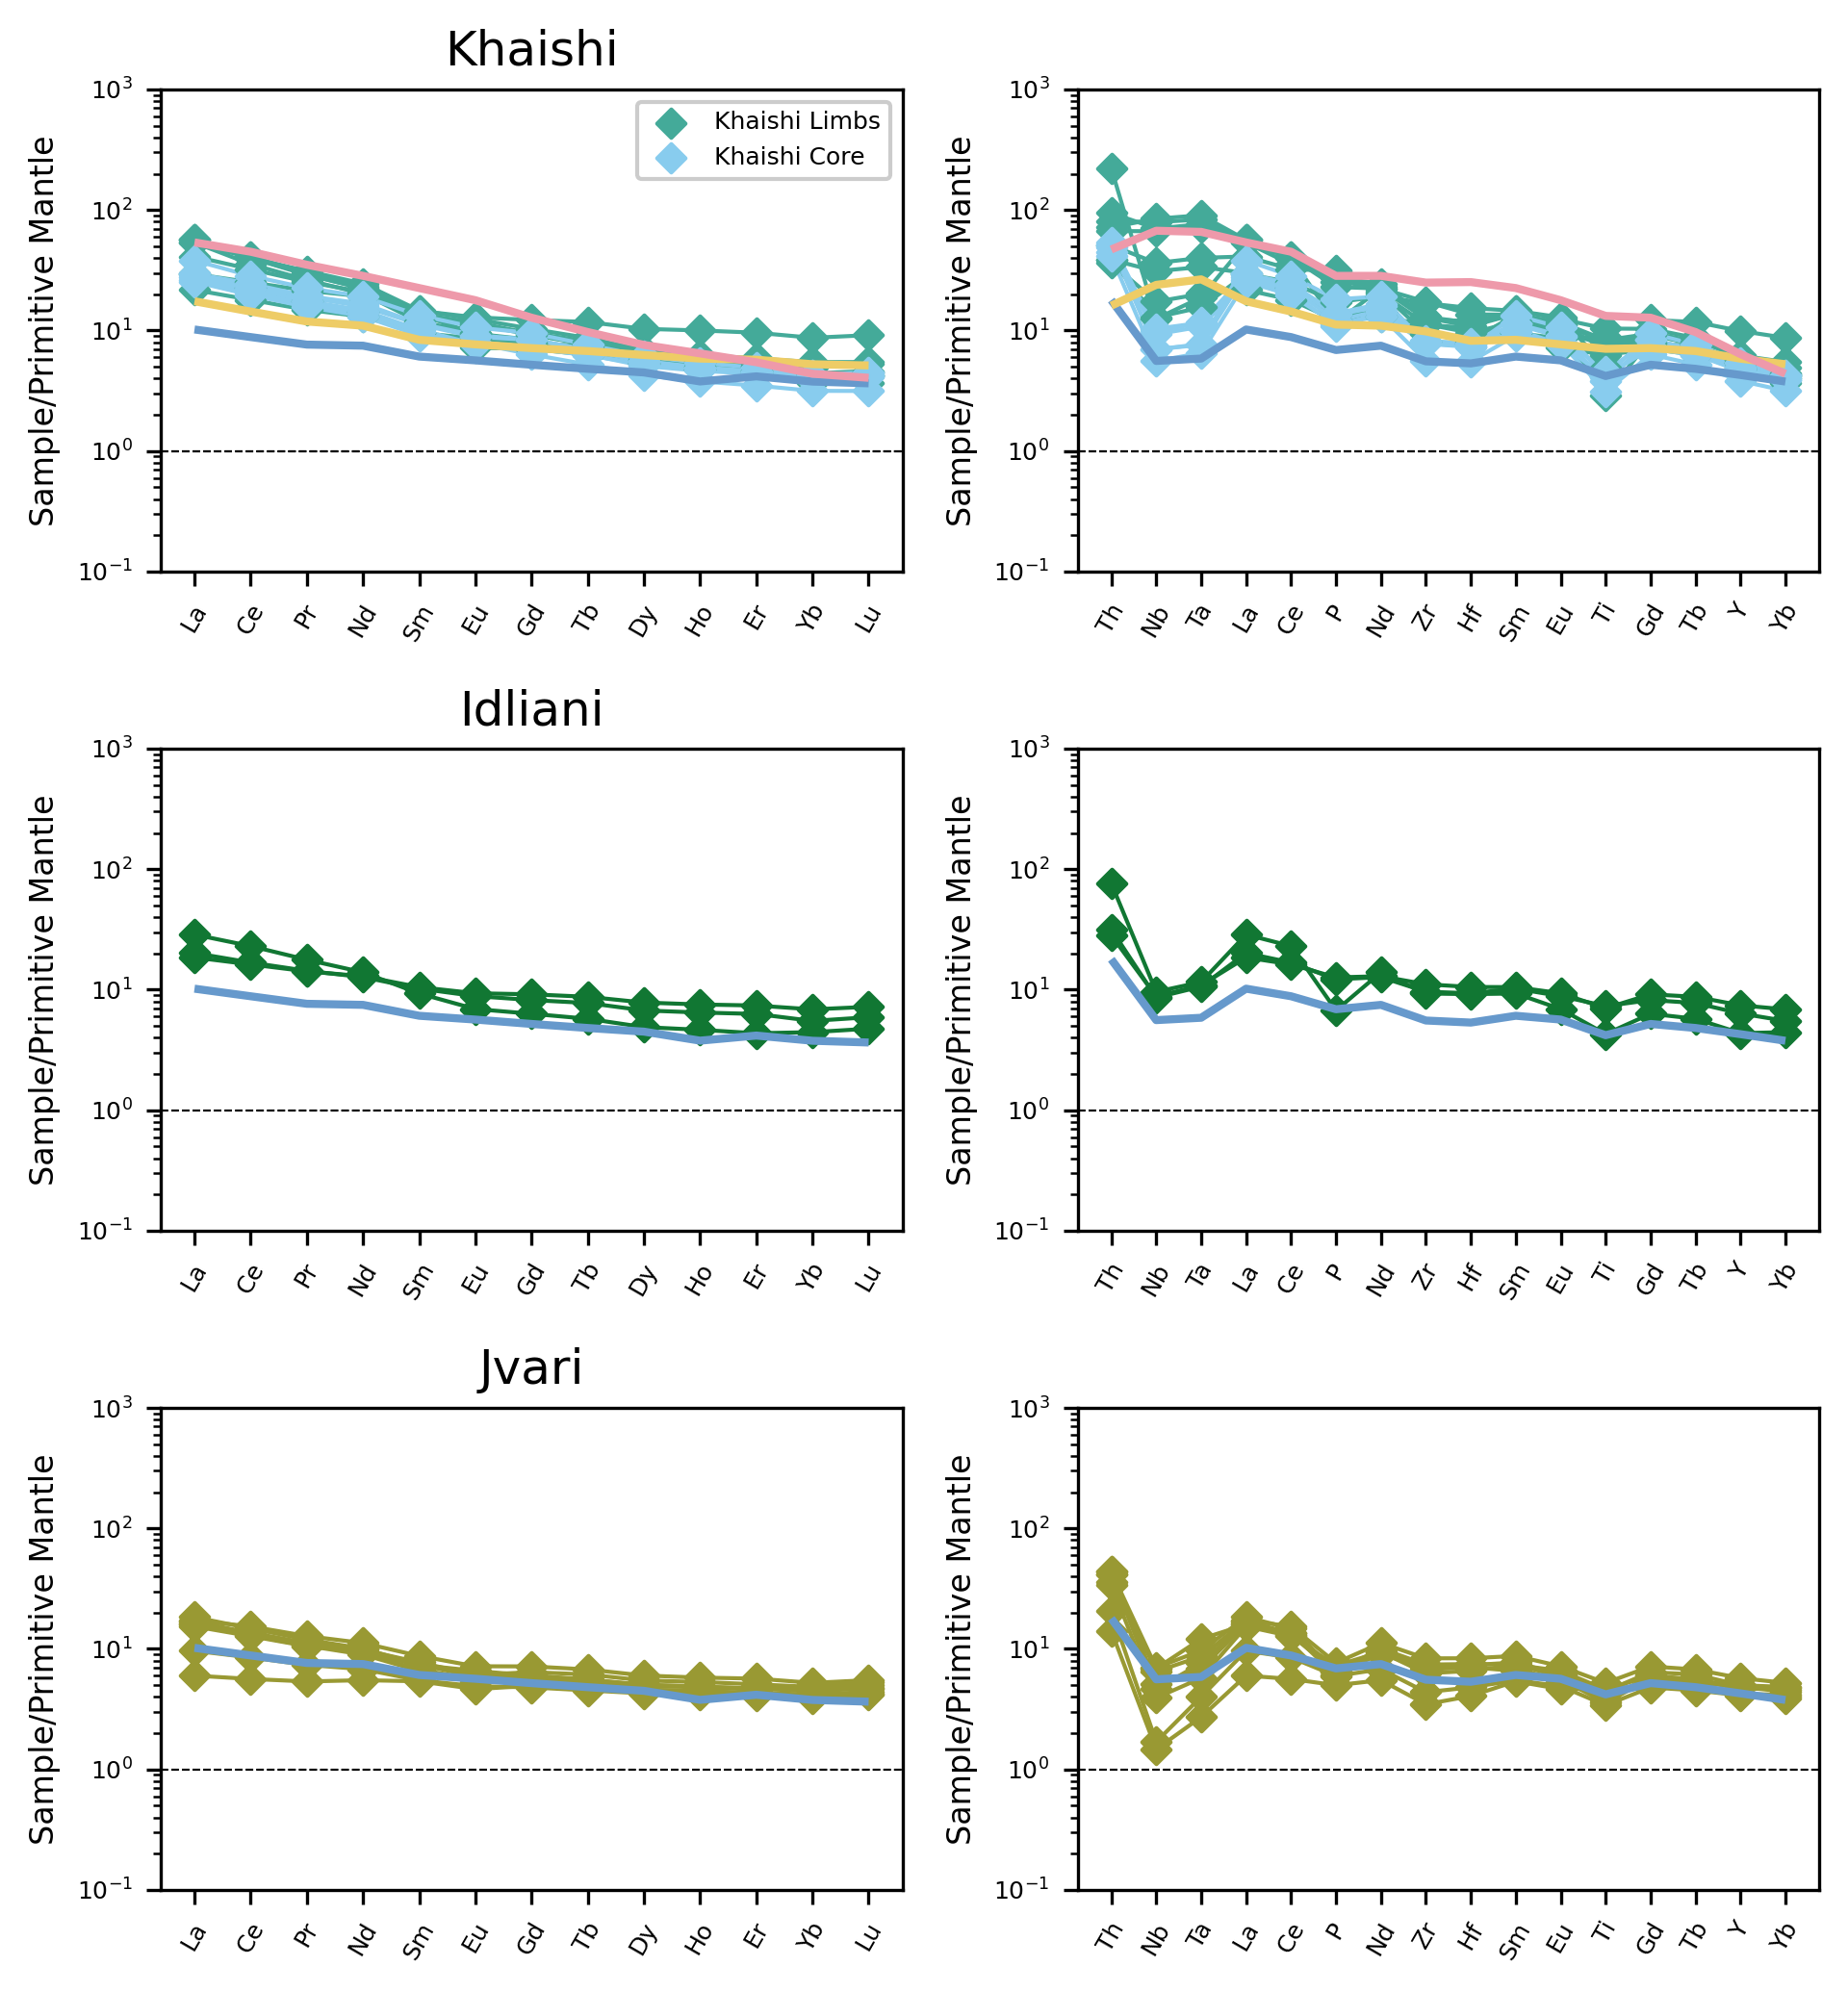

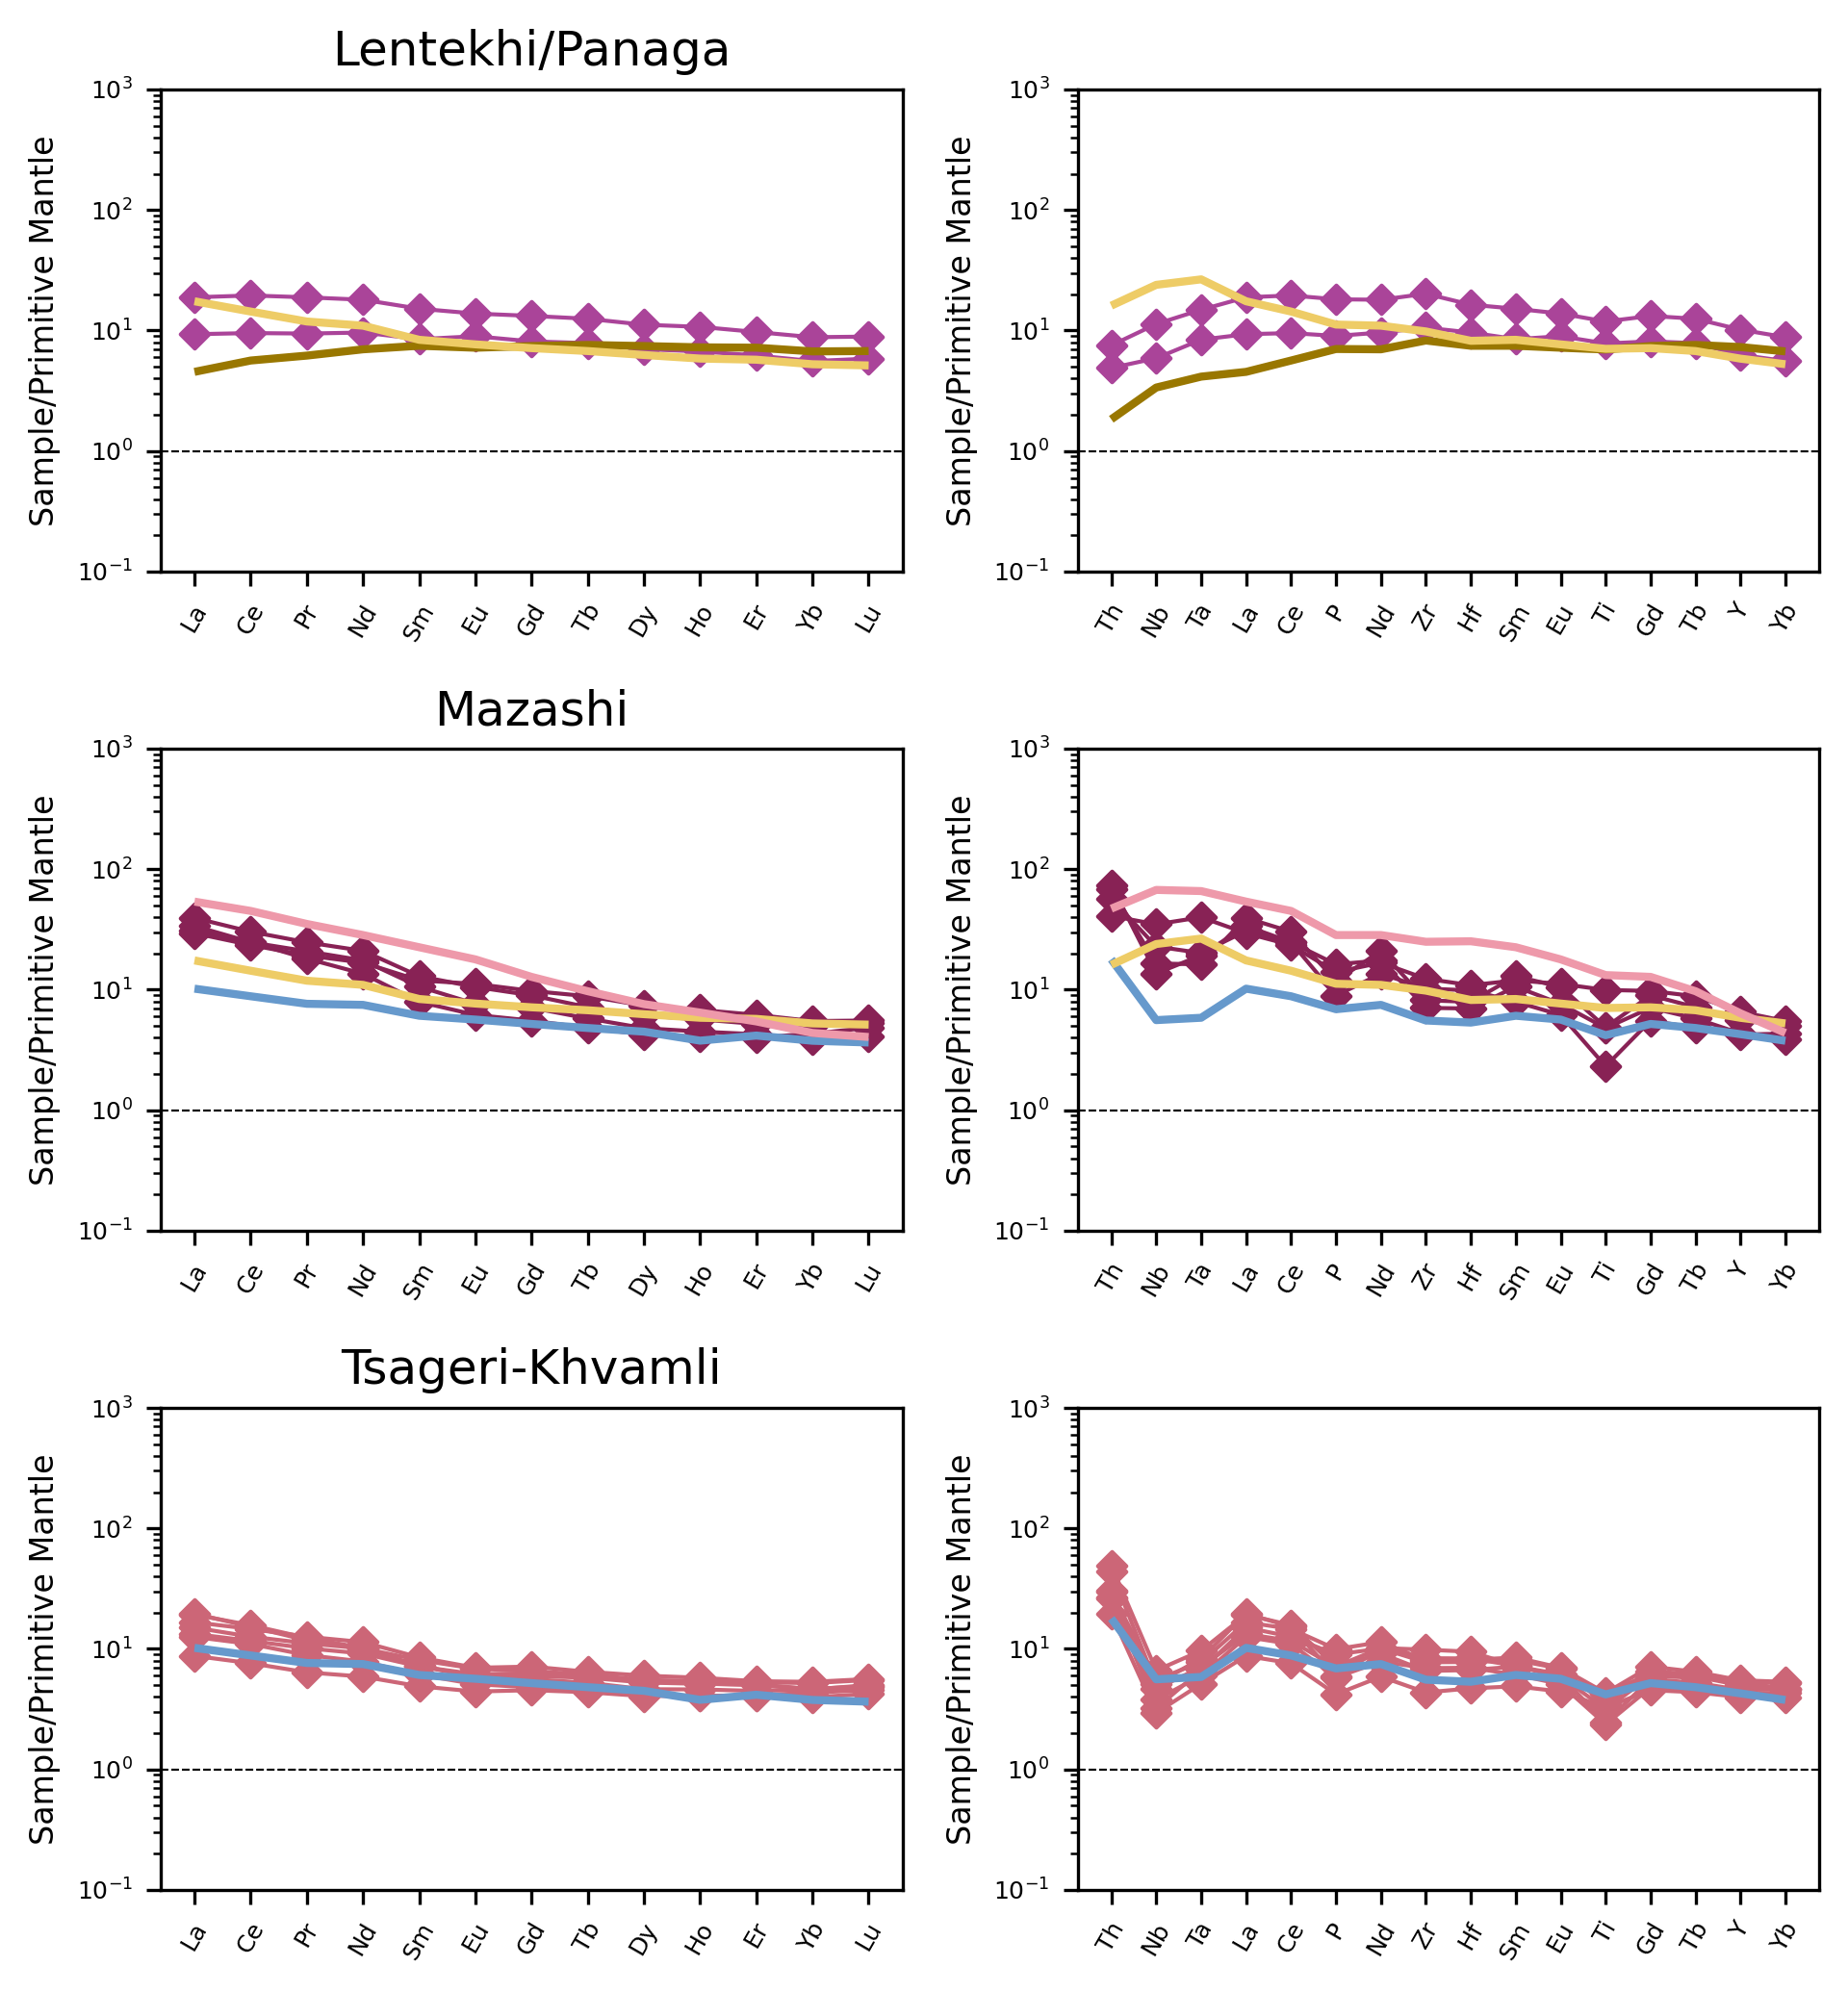

In [9]:
# Spiders

fig0,axs0 = plt.subplots(3,2,figsize=(6.5,7),dpi=300)
fig1,axs1 = plt.subplots(3,2,figsize=(6.5,7),dpi=300)

axs_all = [axs0,axs1]

for k, group in groups:
    fignum = axes_dict[k][1]
    axs = axs_all[fignum]

    ax0 = axs[(axes_dict[k][0],0)]
    ax1 = axs[(axes_dict[k][0],1)]

    ax0.set_title(k)

    gp.REE(group,ax=ax0,c=color_dict[k],label=k)
    gp.immobile(group,ax=ax1,c=color_dict[k],label=k)

axs0[0,0].set_title('Khaishi')
axs0[0,0].legend(fontsize=6,loc='upper right',frameon=True,framealpha=1,facecolor='white')

avgs_list = [['Oceanic Arc','E-MORB','OIB'],['Oceanic Arc'],['Oceanic Arc'],['D-MORB','E-MORB'],['Oceanic Arc','E-MORB','OIB'],['Oceanic Arc']]


for k,ax in enumerate(axs0[:,0]):
    labels = avgs_list[k]
    colors = [avgs_colors[label] for label in labels]
    gp.REE(avgs.loc[labels],ax=ax,marker=None,zorder=2,color=colors,labels=labels,linewidth=2)
for k,ax in enumerate(axs0[:,1]):
    labels = avgs_list[k]
    colors = [avgs_colors[label] for label in labels]
    gp.immobile(avgs.loc[labels],ax=ax,marker=None,zorder=2,color=colors,labels=labels,linewidth=2)
for k,ax in enumerate(axs1[:,0]):
    labels = avgs_list[k+3]
    colors = [avgs_colors[label] for label in labels]
    gp.REE(avgs.loc[labels],ax=ax,marker=None,zorder=2,color=colors,labels=labels,linewidth=2)
for k,ax in enumerate(axs1[:,1]):
    labels = avgs_list[k+3]
    colors = [avgs_colors[label] for label in labels]
    gp.immobile(avgs.loc[labels],ax=ax,marker=None,zorder=2,color=colors,labels=labels,linewidth=2)

fig0.set_layout_engine('tight')
fig1.set_layout_engine('tight')

fig0.savefig(savedir+'F06_westspiders.pdf')
fig1.savefig(savedir+'F07_eastspiders.pdf')

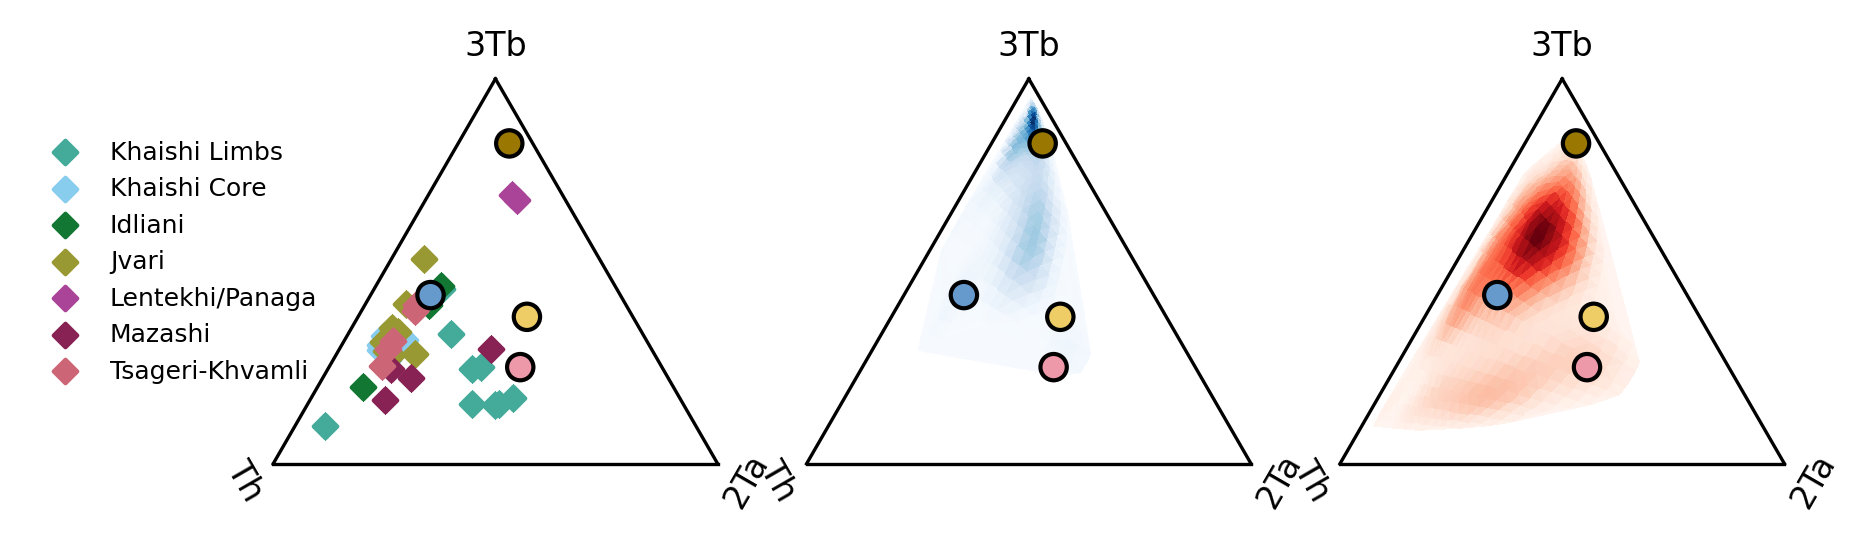

In [10]:
# Cabanis
fig,axs = plt.subplots(1,3,figsize=(6.5,3),dpi=300,subplot_kw={'projection':'ternary'})

first = []
for k,group in groups:
    ax = axs[0]
    Tb,Th,Ta = group[['Tb','Th','Ta']].T.values
    gp.cabanis(Tb,Th,Ta,ax=ax,label=k,c=color_dict[k])

gp.cabanisd(gale['Tb'],gale['Th'],gale['Ta'],ax=axs[1],cmap='Blues')
gp.cabanisd(cbab_spread['Tb'],cbab_spread['Th'],cbab_spread['Ta'],ax=axs[2],cmap='Reds')

for ax in axs:
    colors = [avgs_colors[label] for label in avgs.index]
    gp.cabanis(avgs['Tb'],avgs['Th'],avgs['Ta'],ax=ax,c=colors,marker='o',s=40,edgecolor='black')

axs[0].legend(fontsize=6,loc='best',bbox_to_anchor=(0.15,0.9))

fig.savefig(savedir+'F08_cabanis.pdf')

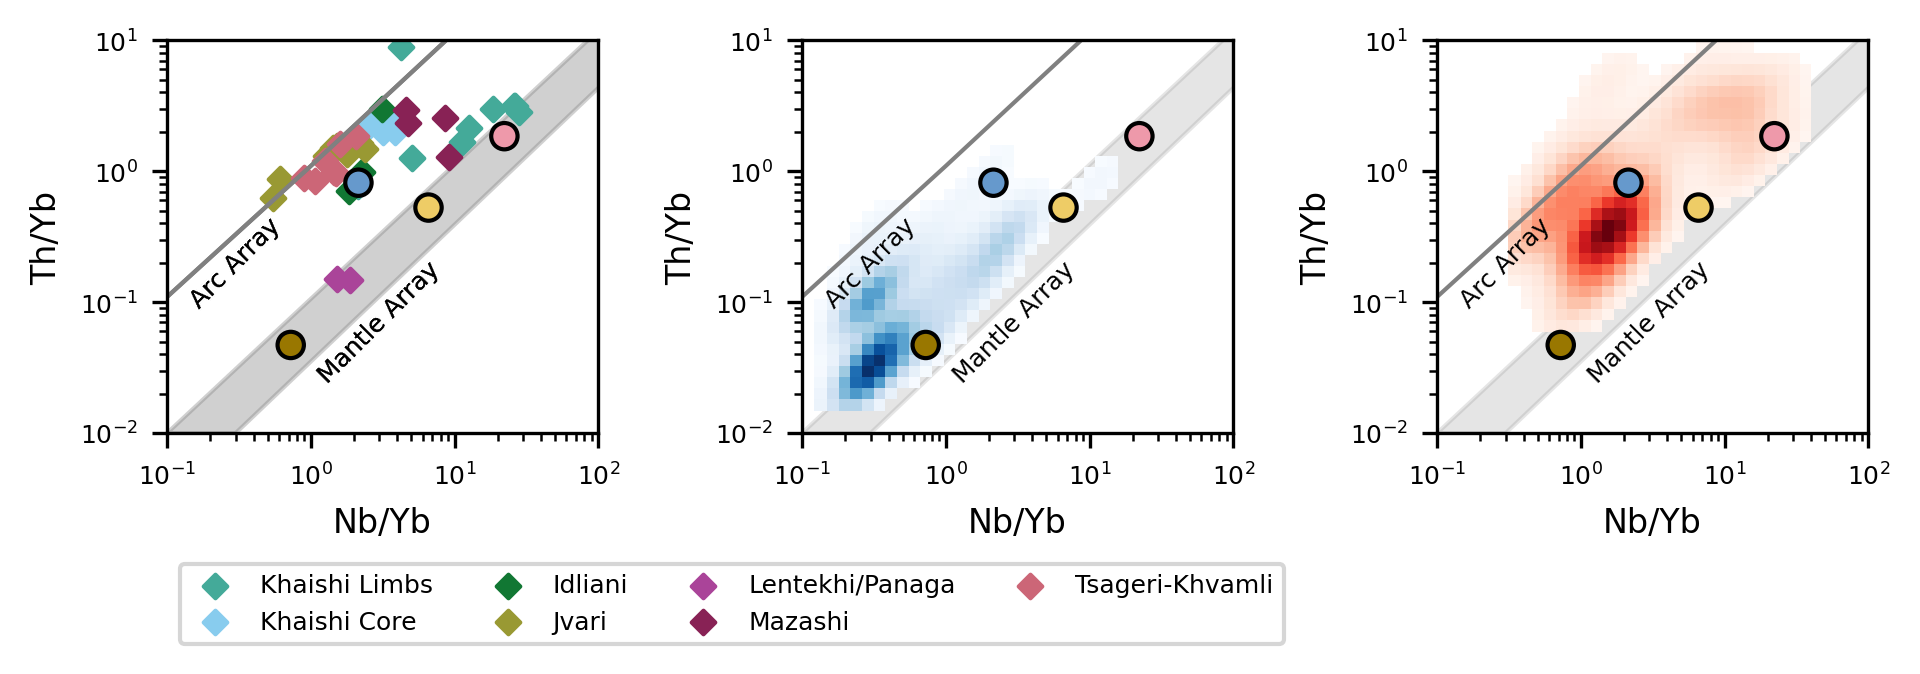

In [11]:
# Mantle Array
fig,axs = plt.subplots(1,3,figsize=(6.5,2),dpi=300)

first = []
for k,group in groups:
    ax = axs[0]
    Th,Nb,Yb = group[['Th','Nb','Yb']].T.values
    gp.mantle_array(Th,Nb,Yb,ax=ax,scatter_kwargs={'label':k,'c':color_dict[k]},first=first)

gp.mantle_array(gale['Th'],gale['Nb'],gale['Yb'],ax=axs[1],scatter=False,density=True,
                density_kwargs={'cmap':'Blues'},first=[])
gp.mantle_array(cbab_spread['Th'],cbab_spread['Nb'],cbab_spread['Yb'],ax=axs[2],scatter=False,
                density=True,density_kwargs={'cmap':'Reds'},first=[])

for ax in axs:
    colors = [avgs_colors[label] for label in avgs.index]
    gp.mantle_array(avgs['Th'],avgs['Nb'],avgs['Yb'],ax=ax,
                    scatter_kwargs={'c':colors,'marker':'o','s':40,'edgecolor':'black'})

    ax.xaxis.get_label().set_fontsize(8)
    ax.yaxis.get_label().set_fontsize(8)
    ax.tick_params(axis='both', which='major', labelsize=6)

plt.tight_layout()
lgd = axs[0].legend(fontsize=6,loc='best',bbox_to_anchor=(0,-0.3),frameon=True,facecolor='white',
              ncols=4)

fig.savefig(savedir+'F09_mantlearray.pdf',bbox_extra_artists=(lgd,),bbox_inches='tight')

In [12]:
# Combine PDFs
pdfs = [savedir+x for x in os.listdir(savedir) if x.startswith('F0')]
pdfs.sort()

merger = PdfWriter()
for pdf in pdfs:
    merger.append(pdf)
merger.write(savedir+'merged_gchem.pdf')
merger.close()